<a href="https://www.kaggle.com/code/anwugit/berlin-student-residence?scriptVersionId=94759977" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Population statistics in Berlin's city administration & Berlin students**

Statistical planning by Berlin's city administration is done based on the "**Lebensweltlich orientierte Räume**" (roughly translated as social life-oriented areas, **LOR** for short) or "Planungsräume" (planning areas). Commonly you would refer to them as neighborhoods or "Kieze" in Berlin slang. Data provided by the city of Berlin will be using these LORs as the smallest spatial areas.

Outside of public administration, usage of these LORs is much more uncommon. An example would be the place of residence of Berlin students, which was provided by the universities of Berlin aggregated by postcodes for anonymization reasons. This leaves us with the obvious problem that LOR and postcode shapes are incompatible and not superimposable.

In this project we aim to:

* **Explore Berlin geospatial statistics with the aid of the Python GeoPandas tools.**
* **Explore where students and 'other' people in Berlin are living according to their LOR or postcode.**
* **Get an estimate of how we can transfer the postcode residence data to the LOR version and make it usable for the Berlin city administration.**
* **Find out where students really prefer to live in Berlin.**

The shapefiles can be downloaded from https://www.stadtentwicklung.berlin.de/planen/basisdaten_stadtentwicklung/lor/de/download.shtml. We'll be using the 2019 version for now since they got overhauled in 2021.

In [1]:
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import seaborn as sns
import geoplot as gplt
import random
import operator
#ignore the warnings stemming from the shapely import
warnings.filterwarnings("ignore", category=UserWarning)
from shapely.geometry import Point
import shapely.speedups
shapely.speedups.enable()

#read the shapefile, explore the data a little
filepath = "../input/berlin-student-residence-data/"
LOR = gpd.read_file(filepath + "Planungsraum_EPSG_25833.shp")
print(LOR.head)
print("We have " + str(len(LOR)) + " LORs in the file.")

#reset the warnings to default
warnings.filterwarnings("default")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


<bound method NDFrame.head of           BEZIRKSREG            BEZIRK  DESKRIPTOR  KLASSE  KLASSENNAM  \
0     Tiergarten Süd             Mitte           7       1  PLR_Fläche   
1     Tiergarten Süd             Mitte           7       1  PLR_Fläche   
2     Tiergarten Süd             Mitte           7       1  PLR_Fläche   
3     Tiergarten Süd             Mitte           7       1  PLR_Fläche   
4     Tiergarten Süd             Mitte           7       1  PLR_Fläche   
..               ...               ...         ...     ...         ...   
445  Allende-Viertel  Treptow-Köpenick           7       1  PLR_Fläche   
446   Altstadt Kietz  Treptow-Köpenick           7       1  PLR_Fläche   
447     Köpenick Süd  Treptow-Köpenick           7       1  PLR_Fläche   
448  Allende-Viertel  Treptow-Köpenick           7       1  PLR_Fläche   
449  Allende-Viertel  Treptow-Köpenick           7       1  PLR_Fläche   

    SCHLUESSEL                                           geometry  
0     0101110

All LORs come with their unique identifier via **SCHLUESSEL**. The individual name and some additional information are also included, though we'll be mainly needing the polygon shapes stored in **geometry**.

The file has 450 rows even though we were expecting 448 LORs according to the documentation. We investigate the dataset and discover 2 indices without LOR/district names, though they have polygon shapes. We'll remove them for now.

In [2]:
#investigate the last rows
print(LOR.iloc[442:,:6])
print(LOR[LOR.KLASSENNAM == "Legende"])
#exclude the rows that have "Legende" in the var KLASSENNAM, unlike the other rows
LOR = LOR[LOR.KLASSENNAM != "Legende"]

#check the number of LORs now
print("We have " + str(len(LOR)) + " LORs in the file.")

                             BEZIRKSREG            BEZIRK  DESKRIPTOR  KLASSE  \
442  West 3 - Borsigwalde/Freie Scholle     Reinickendorf           7       1   
443                                None              None           0       5   
444                                None              None           0       5   
445                     Allende-Viertel  Treptow-Köpenick           7       1   
446                      Altstadt Kietz  Treptow-Köpenick           7       1   
447                        Köpenick Süd  Treptow-Köpenick           7       1   
448                     Allende-Viertel  Treptow-Köpenick           7       1   
449                     Allende-Viertel  Treptow-Köpenick           7       1   

     KLASSENNAM SCHLUESSEL  
442  PLR_Fläche   12304314  
443     Legende       None  
444     Legende       None  
445  PLR_Fläche   09041403  
446  PLR_Fläche   09041501  
447  PLR_Fläche   09041301  
448  PLR_Fläche   09041402  
449  PLR_Fläche   09041401  
    BEZIR

We now have 448 LORs, as expected. We can now add the projection and plot the shapefile on a map and will immediately recognize the outline of Berlin.

In [3]:
#manually set the Coordinate Reference Systems for Berlin
crs = "epsg:25833"
LOR = LOR.set_crs(crs)
LOR.crs

<Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.01, 84.01)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

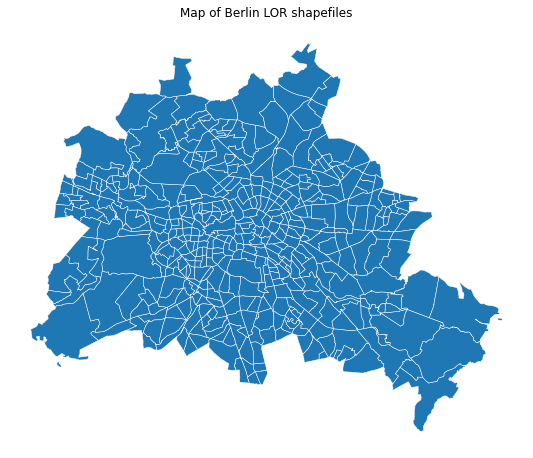

In [4]:
#plotting the shapefile
plt.rcParams['axes.labelsize'] = 16
LOR.plot(edgecolor="white", linewidth=.5, figsize=(8,8))
plt.title("Map of Berlin LOR shapefiles");
plt.tight_layout()
plt.axis("off")
plt.show()

Let's color the 12 single districts of Berlin for visual appeal.

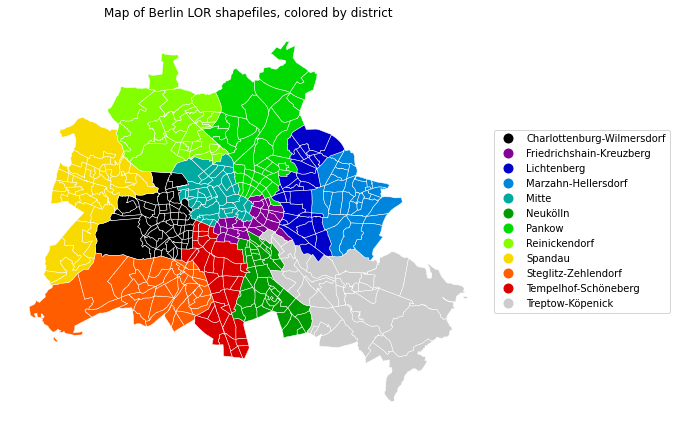

In [5]:
#color by district
ax = LOR.plot(column="BEZIRK", edgecolor="white", linewidth=.5, figsize=(10,10),
              categorical=True, cmap="nipy_spectral", legend=True,  \
              legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5),
                         'fmt': "{:.0f}"}) # fmt is ignored for categorical data
plt.title("Map of Berlin LOR shapefiles, colored by district");
plt.tight_layout()
plt.axis("off")
plt.show()

# **Population data**

Now let's get the data of "normal" inhabitants from https://daten.berlin.de/datensaetze/einwohnerinnen-und-einwohner-berlin-lor-planungsr%C3%A4umen-am-31122020.

**RAUMID** is the 8-digit identifier that can be linked to the **SCHLUESSEL** used in the LOR dataset. **E_E** refers to the number of inhabitants in total, while the other **E_** variables describe sex, age and so on. We'll merge both datasets.

In [6]:
#import the demograpic data
EWR = pd.read_csv(filepath + "EWR.csv",sep=";")
print(EWR.head)

#convert the LOR identifier to int64 for merging
LOR["SCHLUESSEL"] = LOR["SCHLUESSEL"].astype(int)

#rename the EWR identifier to "SCHLUESSEL", then merge
EWR.rename(columns={"RAUMID":"SCHLUESSEL",
                   "E_E":"population"}, inplace=True)
EWR = EWR.set_index("SCHLUESSEL")
LOR = LOR.merge(EWR, on="SCHLUESSEL")

<bound method NDFrame.head of        ZEIT    RAUMID  BEZ  PGR  BZR  PLR  STADTRAUM    E_E  E_EM  E_EW  ...  \
0    202012   1011101    1    1   11    1          1   3419  1796  1623  ...   
1    202012   1011102    1    1   11    2          1    192   121    71  ...   
2    202012   1011103    1    1   11    3          1   5211  2783  2428  ...   
3    202012   1011104    1    1   11    4          1   4636  2563  2073  ...   
4    202012   1011105    1    1   11    5          1   1599   882   717  ...   
..      ...       ...  ...  ...  ...  ...        ...    ...   ...   ...  ...   
443  202012  12302110   12   30   21   10          2  10656  5211  5445  ...   
444  202012  12302211   12   30   22   11          2   3310  1629  1681  ...   
445  202012  12302212   12   30   22   12          2   5922  2961  2961  ...   
446  202012  12304313   12   30   43   13          2   6750  3399  3351  ...   
447  202012  12304314   12   30   43   14          2   9665  4482  5183  ...   

     E_E9

Let's plot the population per LOR.

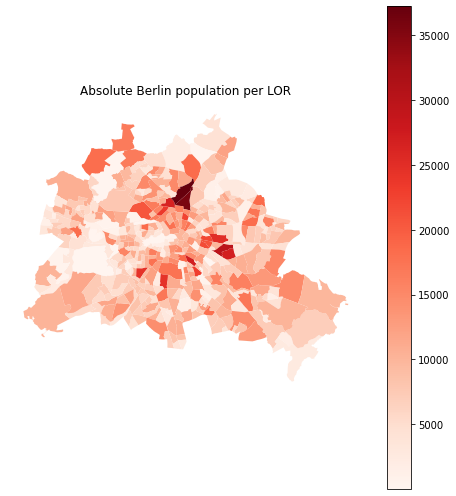

In [7]:
#plot total population by LOR
LOR.plot(column="population", legend=True, cmap="Reds", figsize=(7,7));
plt.title("Absolute Berlin population per LOR");
plt.tight_layout()
plt.axis("off")
plt.show()

# **Some basic population statistics**

Without considering the size of an area this data is hardly meaningful. Calculating total population, area and density yield the exact values of Berlin's data, so we can assume that this dataset is correct.

We also do some basic statistics. LORs can have anything from 6 to 37240 inhabitants, while the average LOR has 8415 people.

         population   area_sqkm   pop_density
count    448.000000  448.000000    448.000000
mean    8415.093750    1.988093   8775.683219
std     5535.550236    3.016866   7126.361846
min        6.000000    0.133767      3.359494
20%     3862.600000    0.558381   2332.318021
40%     6396.200000    0.853188   4879.722185
50%     7470.000000    1.045880   6686.189788
60%     8781.600000    1.376314   9774.411200
80%    11718.200000    2.313041  14951.247876
max    37240.000000   23.725818  32315.171981
3769962 people are living in an area of 890.6654453687615km² with a density of 4232.747570485488 people/km².
8775.68321894074


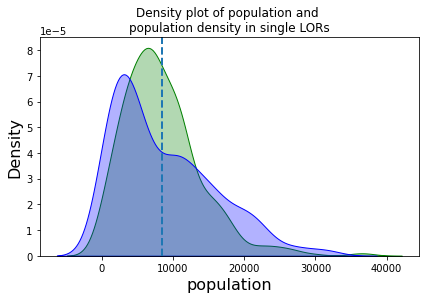

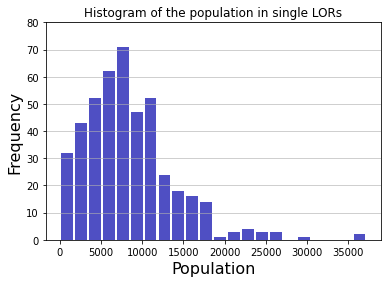

In [8]:
#calculate area size from the polygons
LOR["area_sqkm"] = LOR["geometry"].area / 10**6

#calculate population density per LOR
LOR["pop_density"] = LOR["population"] / LOR["area_sqkm"]

perc = [.20, .40, .60, .80]
print(LOR[["population","area_sqkm","pop_density"]].describe(percentiles=perc))

print(str(sum(LOR["population"])) + " people are living in an area of " + str(sum(LOR["area_sqkm"])) + "km² with a density of " + str(sum(LOR["population"]) / sum(LOR["area_sqkm"])) + " people/km².")

#visual plots
mean_val_ax1 = np.mean(LOR["population"])
mean_val_ax2 = np.mean(LOR["pop_density"])
print(mean_val_ax2)

plt.title("Density plot of population and \npopulation density in single LORs");
plt.tight_layout()
ax1 = sns.kdeplot(LOR["population"], shade=True, color="g", label="Cyl=4", alpha=.3)
ax2 = sns.kdeplot(LOR["pop_density"], shade=True, color="b", label="Cyl=4", alpha=.3)
# vertical dotted line originating at mean value
plt.axvline(mean_val_ax1, linestyle='dashed', linewidth=2)
plt.show()

n, bins, patches = plt.hist(x=LOR["population"], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Histogram of the population in single LORs')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

# **Density estimation**

Plotting the population density of LORs shows that the inner districts are more densely populated, as expected. Let's try to get a smoother image through a kernel density estimation, though.

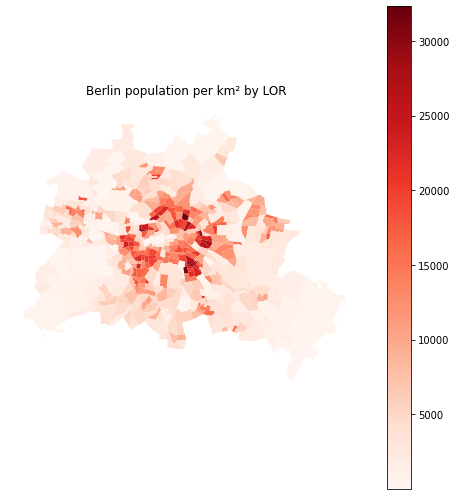

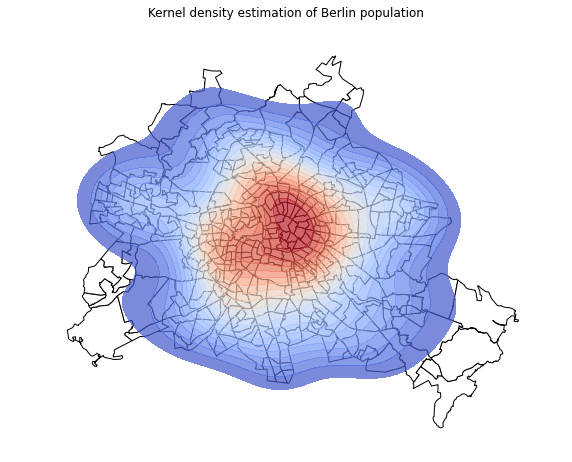

In [9]:
#plot total population per LOR
LOR.plot(column="pop_density", legend=True, cmap="Reds", figsize=(7,7));
plt.title("Berlin population per km² by LOR");
plt.tight_layout()
plt.axis("off")
plt.show()

#plot the Berlin map with a kernel-density estimation on top
LOR.plot(color="white", edgecolor='black', figsize=(10,10))
ax = sns.kdeplot(data=LOR,
            x=LOR["geometry"].centroid.x, 
            y=LOR["geometry"].centroid.y, 
            fill=True,
            cmap='coolwarm',
            alpha=0.7, 
            gridsize=200,
            levels=20,
            #clip=unLOR, #one day...
            weights=LOR["population"])
plt.title("Kernel density estimation of Berlin population");
plt.gca().set_facecolor("#a2aae9")
plt.axis("off")
plt.show()

# **Postcodes and student residence data**
Now let's get to the students. We'll read the German postcode shapefiles and limit them to Berlin (10115-14199). It's publicly available on https://daten.odis-berlin.de/de/dataset/plz/. Note that we have 190 post codes in Berlin but 194 shapes since some post codes are split into multiple areas. Plotting them against the LOR shapes shows that their borders have nothing in common at all, except for the outer city boundaries. So how can we determine what LOR the students are living in if our residence data is based on postcodes?

We have 190 postcodes in the file.


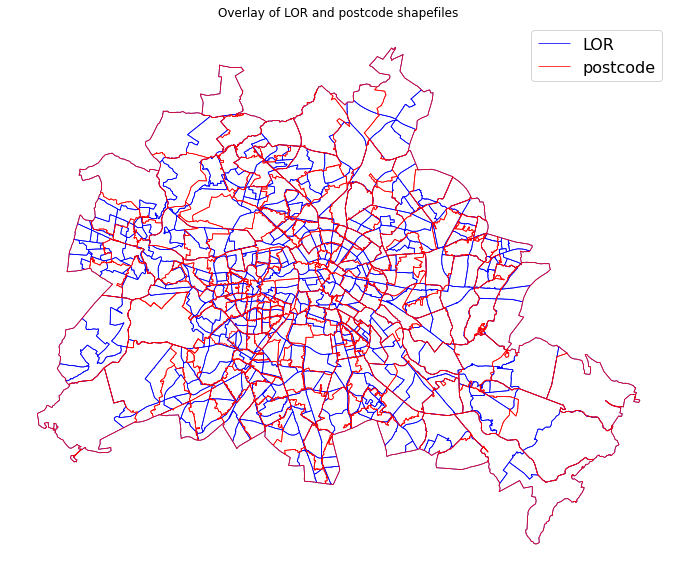

In [10]:
#read the shapefile, explore the data a little
PLZ_shape = gpd.read_file(filepath + "plz.shp", encoding='utf-8')

#convert PLZ to a number
PLZ_shape["plz"] = PLZ_shape["plz"].astype(int)
#range of Berlin postcodes is 10115–14197 so let's create a subset
PLZ_import = PLZ_shape.loc[PLZ_shape["plz"] >= 10115].loc[PLZ_shape['plz'] <= 14197]
#set the projection
PLZ_import = PLZ_import.set_crs(crs, allow_override=True)

print("We have " + str(len(PLZ_import)) + " postcodes in the file.")

#overlaying LOR and PLZ (postcode) shapefile
#ref: https://geopandas.org/en/stable/docs/user_guide/mapping.html
ax = LOR.boundary.plot(color="blue", linewidth=0.75, figsize=(10,10), label="LOR")
ax.set_aspect('equal')
PLZ_import.boundary.plot(color="red",linewidth=0.75, ax=ax, label="postcode")

#add legend
handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
handles2, labels2 = zip(*hl)

ax.legend(handles2, labels2, prop={'size': 16})
plt.title("Overlay of LOR and postcode shapefiles");
plt.tight_layout()
plt.axis("off")
plt.show()

Let's import the number of students living in each Berlin postcode as of 2016. This data was obtained from the Berlin city government for research reasons and is not available publicly, unfortunately. Some simple statistics tell us that about 110,000 students lived in Berlin in 2016 with an average of 579 per postcode, as a few as 6 in a single postcode area.

       plz                                           geometry  students
0    10115  POLYGON ((389163.210 5821872.935, 389165.641 5...      1460
1    10117  POLYGON ((389678.019 5820987.307, 389712.823 5...       665
2    10119  POLYGON ((391390.987 5820861.119, 391369.354 5...      1467
3    10178  POLYGON ((391390.987 5820861.119, 391546.214 5...       593
4    10179  POLYGON ((391627.933 5819203.750, 391758.914 5...       636
..     ...                                                ...       ...
185  14193  POLYGON ((377752.447 5818162.863, 378080.009 5...       361
186  14195  POLYGON ((384021.278 5812001.900, 384000.851 5...       459
187  14197  POLYGON ((385109.793 5814435.660, 385111.518 5...       508
188  12439  POLYGON ((398258.040 5813688.224, 398268.004 5...       232
189  14055  POLYGON ((381294.435 5819489.719, 381357.763 5...       396

[190 rows x 3 columns]
          students
count   190.000000
mean    578.847368
std     518.363811
min       6.000000
20%     247.60000

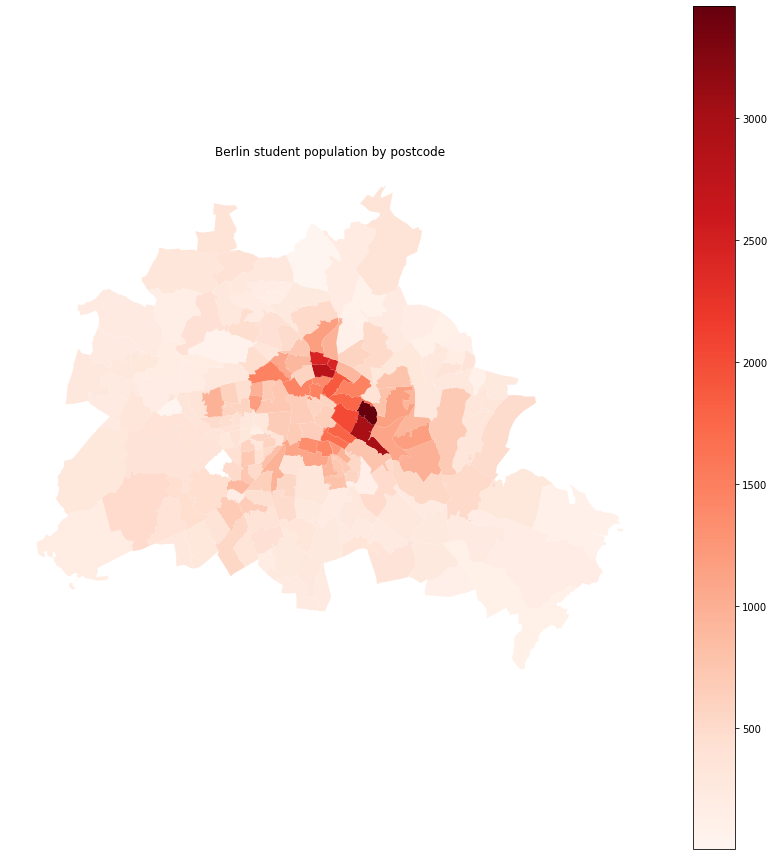

In [11]:
#import the demographic student data
stud_import = pd.read_csv(filepath + "studPLZ.csv", sep=";")

#limit the data to Berlin postcodes (10115-14197)

stud_pop = stud_import.loc[stud_import['PLZ'].astype(int) >= 10115].loc[stud_import['PLZ'].astype(int) <= 14197]
#199 rows, remove duplicate postcodes
stud_pop_nodupes = stud_pop.drop_duplicates(subset=['PLZ'])

#rename columns to prepare for merge
stud_pop_renamed = stud_pop_nodupes[["PLZ","Studierende"]].rename(columns={"PLZ":"plz",
                                       "Studierende":"students"})

#merge both
PLZ = PLZ_import.merge(stud_pop_renamed, on="plz", how="left")
print(PLZ)
print(PLZ[["students"]].describe(percentiles=perc))
print("There are " + str(sum(PLZ["students"])) + " students living in Berlin.")

PLZ.plot(column="students", legend=True, cmap="Reds", figsize=(12,12));
plt.title("Berlin student population by postcode");
plt.tight_layout()
plt.axis("off")
plt.show()

# **Distribute students randomly, then re-assign them to LOR shapes**

We know the exact number of students living in each postcode but for anonymization reasons we don't know their exact location. Let's distribute them randomly across the polygon as spatial data points, then assign them to the LOR that they happened to fall into.

Creating 109981 points.


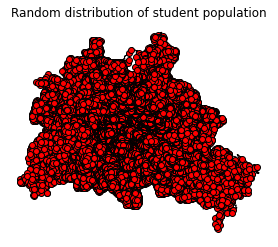

In [12]:
#define a function to create random points that are certain to be inside the polygon
#https://gis.stackexchange.com/questions/294394/randomly-sample-from-geopandas-dataframe-in-python
random.seed(1337)
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point

#go through each PLZ, get random points equal to 10% of the student population, create a list of them
studpop_points = []
for i in range(len(PLZ)):
    studpop_points_i = random_points_in_polygon(PLZ.iloc[i].students, PLZ.iloc[i].geometry)
    # / 10
    studpop_points = studpop_points + studpop_points_i
    
print("Creating " + str(len(studpop_points)) + " points.")

#now plot our points
f, ax = plt.subplots(1)
df1 = PLZ.geometry
studpop_geo = gpd.GeoSeries((studpop_points),crs=crs)
df1.plot(ax=ax, facecolor='none', edgecolor='k');
studpop_geo.plot(ax=ax, facecolor="red", edgecolor='k');
plt.title("Random distribution of student population");
plt.axis("off")
plt.show()

Now determine what LOR the points fell into and assign the respective LOR key.

In [13]:
#https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
#create new dataframe with the point geometry a placeholder for the to-be-determined LOR
pip_data = pd.DataFrame(data = {"geometry": studpop_geo, "LOR": "0"})

#go through each LOR, find the student points that fall within, assign the respective LOR key
for i in range(len(LOR)):
    pip_mask = studpop_geo.within(LOR.loc[i, "geometry"])
    pip_data.loc[pip_mask == True, "LOR"] = LOR["SCHLUESSEL"][i]
    
print(pip_data)

                              geometry      LOR
0       POINT (390648.367 5821483.834)  1011401
1       POINT (390042.756 5821581.013)  1011301
2       POINT (389561.544 5822022.461)  1011301
3       POINT (390085.686 5821958.144)  1011401
4       POINT (390844.197 5821141.233)  1011401
...                                ...      ...
109976  POINT (380813.095 5819463.838)  4020207
109977  POINT (379569.641 5819108.544)  4020206
109978  POINT (382282.191 5817640.550)  4020209
109979  POINT (379194.343 5819373.699)  4020206
109980  POINT (382054.697 5818829.115)  4020209

[109981 rows x 2 columns]


Let's count how many students live in each LOR district. Since we have only 446 rows 2 LORs indeed have no students at all.

In [14]:
#count students by LOR district
studentsPLZ = pip_data.groupby(["LOR"], as_index=False, sort=True).size()
studentsPLZ.rename(columns={"LOR":"SCHLUESSEL", "size":"students"}, inplace=True)
print(studentsPLZ)

LOR = LOR.merge(studentsPLZ, on="SCHLUESSEL", how="left")

#replace missing numbers with 0 and convert to integer
LOR["students"] = LOR["students"].fillna(0).astype("int64")

print("There are " + str(sum(LOR["students"])) +  " students living in Berlin.")

     SCHLUESSEL  students
0       1011101        87
1       1011102       591
2       1011103       134
3       1011104        59
4       1011105       239
..          ...       ...
441    12302110        40
442    12302211        94
443    12302212        20
444    12304313       128
445    12304314       119

[446 rows x 2 columns]
There are 109981 students living in Berlin.


To finish, let's visually check where students are living in Berlin.

0      237.189710
1      196.383523
2      256.530484
3      174.379065
4      255.737995
          ...    
443      9.042879
444     37.648495
445     11.696883
446      6.396372
447      0.000000
Name: stud_density, Length: 448, dtype: float64


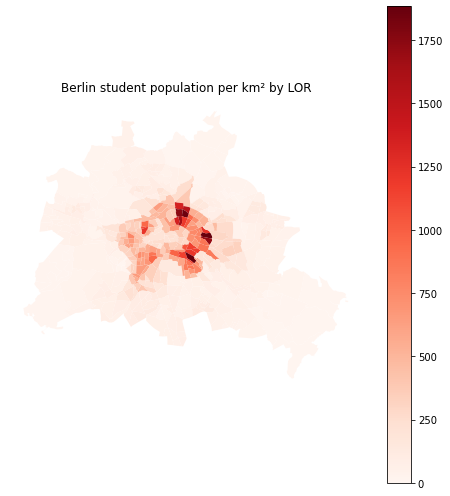

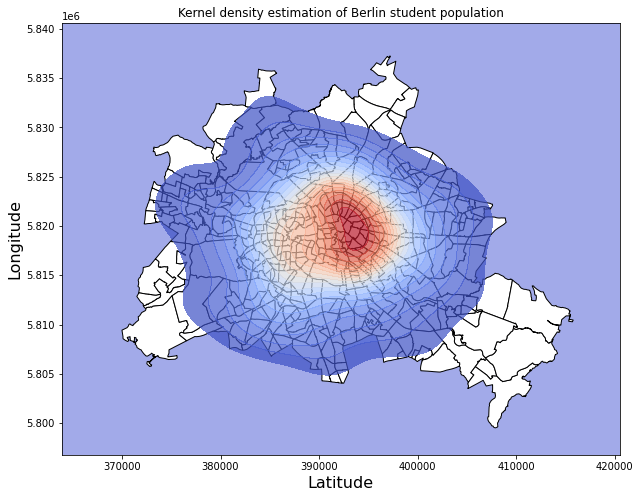

In [15]:
#calculate student density per LOR
LOR["stud_density"] = LOR["students"] / LOR["area_sqkm"]
print(LOR["stud_density"])
LOR.to_csv("LOR.csv", encoding="utf-8", index=False)

#plot total student population per LOR
LOR.plot(column="stud_density", legend=True, cmap="Reds", figsize=(7,7));
plt.title("Berlin student population per km² by LOR");
plt.tight_layout()
plt.axis("off")
plt.show()

#plot the Berlin map with a kernel-density estimation on top
LOR.plot(color="white", edgecolor='black', figsize=(10,10))
ax = sns.kdeplot(data=LOR,
            x=LOR["geometry"].centroid.x, 
            y=LOR["geometry"].centroid.y, 
            fill=True,
            cmap='coolwarm',
            alpha=0.7, 
            gridsize=200,
            levels=20,
            weights=LOR["students"])
plt.title("Kernel density estimation of Berlin student population");
plt.gca().set_facecolor("#a2aae9")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

# **Conclusion**

Like most young people, students seem to prefer living in the city center. The student density is obviously affected by the generally higher population density in the center in general. Nevertheless, our goal of transferring our student residence data to another spatial system, was successful.